# Sentimental Analysis of Product based reviews 

###         Importing the required packages

In [1]:
#!pip install wordcloud
#!pip install xgboost

In [2]:
import os
import time
Time_Start=time.time()


# ignore warinings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd  

import numpy as np   

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

# from sklearn.model_selection import  train_test_split 

from sklearn.metrics import roc_curve, auc

from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC

from sklearn.naive_bayes import MultinomialNB , BernoulliNB

from sklearn.ensemble import RandomForestClassifier 

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

from wordcloud import WordCloud

from collections import Counter

from pylab import rcParams

import statistics 

import string

import re

import nltk

from nltk.corpus import words

from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords

In [4]:
# current working directory
print(os.getcwd(),"\n")

C:\Users\Rithish Miryala\mini\code 



In [5]:
# Input data files are available in the read-only "dataset/" directory
# For example, running below cell will list all files under the dataset directory

## Reading and Organising the Dataset

In [6]:
# collecting all the datasets and concatenating them to a single dataframe
datasets=[]
for dirname, _, filenames in os.walk('dataset/'):
    for filename in filenames:
        filepath=os.path.join(dirname, filename)
        print(filepath)
        datasets.append(filepath)

# creating a empty dataframe
amazon_data=pd.DataFrame()

# adding all the datasets to the amazon_data dataframe
for i in datasets:
    amazon_data=pd.concat([amazon_data,pd.read_csv(i)])



dataset/Amazon_Unlocked_Mobile.csv


### Data cleaning

In [7]:
print("\nShape of dataset : ",amazon_data.shape)
amazon_data.drop_duplicates(inplace=True)
print("\nShape of dataset after removing duplicates : ",amazon_data.shape)


Shape of dataset :  (413840, 6)

Shape of dataset after removing duplicates :  (349761, 6)


In [8]:
# information about dataframe 
print(amazon_data.info())
print("\n\nNull values in each row  :\n\n",amazon_data.isna().sum())
print("\nTotal null values in dataset  :  ",amazon_data.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349761 entries, 0 to 413829
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  349761 non-null  object 
 1   Brand Name    295024 non-null  object 
 2   Price         344524 non-null  float64
 3   Rating        349761 non-null  int64  
 4   Reviews       349710 non-null  object 
 5   Review Votes  337487 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.7+ MB
None


Null values in each row  :

 Product Name        0
Brand Name      54737
Price            5237
Rating              0
Reviews            51
Review Votes    12274
dtype: int64

Total null values in dataset  :   72299


In [9]:
# Removinging all the rows with null values
print("Shape of dataset before dropping null  :  ",amazon_data.shape )
amazon_data=amazon_data.dropna(axis =0)

print("\nShape of dataset after dropping null   :  ",amazon_data.shape ,"\n")
amazon_data

Shape of dataset before dropping null  :   (349761, 6)

Shape of dataset after dropping null   :   (281254, 6) 



,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413825,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,"Great phone. Large keys, best flip phone I hav...",0.0
413826,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,"Pros...Works great, very durable, easy to navi...",0.0
413827,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,just as described perfect for the price,0.0
413828,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,1,Would not work,0.0


In [10]:
print("Rating values in dataset are : ", sorted(amazon_data.Rating.unique()))

Rating values in dataset are :  [1, 2, 3, 4, 5]


In [11]:
print("Features are \n",amazon_data.columns)

Features are 
 Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes'],
      dtype='object')


In [12]:
# statistics of the dataframe
print("Features are \n",amazon_data.describe())

Features are 
                Price         Rating   Review Votes
count  281254.000000  281254.000000  281254.000000
mean      224.784278       3.785774       1.552742
std       288.532131       1.553943       9.697557
min         1.730000       1.000000       0.000000
25%        75.990000       3.000000       0.000000
50%       139.000000       5.000000       0.000000
75%       264.680000       5.000000       1.000000
max      2598.000000       5.000000     645.000000


In [13]:
# here the target variable is Rating
# we are dealing with reviews whether they are positive or negative
# and also ratings to compare with predicted rating value and get the accuracy score
# so we consider only reviews and rating to be features for the dataframe
amazon_data=amazon_data[["Reviews","Rating"]] 
amazon_data.head()

,Reviews,Rating
0,I feel so LUCKY to have found this used (phone...,5
1,"nice phone, nice up grade from my pantach revu...",4
2,Very pleased,5
3,It works good but it goes slow sometimes but i...,4
4,Great phone to replace my lost phone. The only...,4


Value Count graph for each rating


<AxesSubplot:>

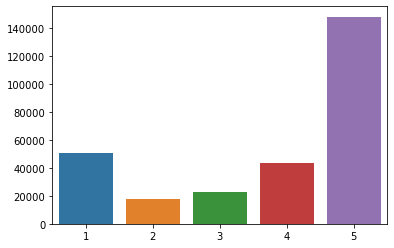

In [14]:
print("Value Count graph for each rating")
sns.barplot(x=amazon_data.Rating.value_counts().index,y=amazon_data.Rating.value_counts().values)

In [15]:
# function to calculate time taken 
def calcTime(startTime):
    endTime=time.time()
    Time=(endTime-startTime)
    return str(round(Time/60.0,4))+" min  or  "+str(round(Time,4))+" sec"

## Data Preprocessing

In [16]:
# retrieving Stopwords
STOPWORDS=stopwords.words("english") 
print("Stop words  ::: \n",STOPWORDS)

Stop words  ::: 
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same

In [17]:
# required words are
required=["not" ,"no" ,"nor"] 

# removing some required words from stopwords 
STOPWORDS=list(set(STOPWORDS)-set(required))
type(set(STOPWORDS))
print("Final Stopwords  :::\n",STOPWORDS)

Final Stopwords  :::
 ['with', "she's", 'on', 'because', 'we', 'be', "hasn't", "haven't", 'had', 'being', 'or', 'from', 'were', 'hadn', "aren't", "it's", 'then', 'shouldn', 'all', 'just', 'having', 'haven', 'shan', 'this', 'there', 'now', 'which', 'll', 'needn', 'it', 'i', 'in', 'but', 'was', 'did', 'as', 'until', 'each', 'more', 'their', 'his', 'him', 'into', "mightn't", 'if', 'through', 'you', 'before', "should've", 'my', 'wasn', 'our', 'couldn', 'and', "you're", 'isn', 'for', 'most', 'they', 'where', 't', "isn't", 'doesn', 'weren', 're', 'between', 'ourselves', 'above', 'here', "shan't", 'is', 'the', 'further', 'are', 'why', 'so', 'any', 'some', "that'll", 'can', 'your', "weren't", 'm', 'will', 'to', 'she', "wasn't", 'hers', 'out', 'again', 'an', 'yourselves', 'about', 'a', 'own', 'aren', 'won', "won't", 'yourself', 'of', 'd', 'me', 'hasn', 'by', 'should', 'been', 'doing', 'such', 'up', 'don', 'against', 'her', 'who', 'these', 'other', "needn't", 'itself', 'myself', 'do', 'after', '

In [18]:
# downloading words in english dictionary 
nltk.download('words')

# downloading wordnet for Lemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package words to C:\Users\Rithish
[nltk_data]     Miryala\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rithish
[nltk_data]     Miryala\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
setofwords = set(words.words())
print("some of the words in dictionary    :::\n",list(setofwords)[:50])

some of the words in dictionary    :::
 ['dentiparous', 'Aktistetae', 'bodice', 'sesquioxide', 'Endamoebidae', 'otocariasis', 'Cabomba', 'plicatile', 'sloper', 'parcheesi', 'thone', 'modernish', 'convocant', 'morglay', 'saving', 'untripping', 'otoantritis', 'birdcall', 'melismatics', 'endomorphism', 'bannerol', 'quadrupedantic', 'Sterna', 'overslow', 'viziercraft', 'nonsolicitation', 'axonal', 'irretrievability', 'lathereeve', 'interfluous', 'vermicide', 'weedy', 'cytogenetic', 'gandul', 'hatless', 'Banbury', 'daub', 'impropriation', 'pseudoplasma', 'cholanic', 'ultrabrachycephaly', 'Seamas', 'perfervour', 'permonosulphuric', 'grateless', 'petiolule', 'impassion', 'Hemileia', 'cooling', 'preinterpretative']


### Filtering the Text

In [20]:
# Using Lemmatising to convert words into their common base form
lemmatizer = WordNetLemmatizer()

def deEmojify(inputString):#to remove emojis in the text.
    try:
        return inputString.encode('ascii', 'ignore').decode('ascii') 
    except:
        return inputString
   #most common unnecessary words. eg is, he, that, etc

def filter_text(text):
    text=re.sub('\n+', ' ', text)
    text=deEmojify(str(text))
    text_cleaned=re.sub(' +', ' ', text) # remove extra white spaces
    
    text_cleaned=text_cleaned.lower() # converting to lowercase
    tokens=text_cleaned.split(" ")
    
    ftokens=[]
    for token in tokens:
        if token!='':
            if "n't" in token:
                ftokens.append('not')
            elif token not in STOPWORDS:
                ftokens.append(token)
    tokens=[]
    for token in ftokens:
        st=[]
        for x in token:
            if x not in string.punctuation:
                st.append(x)
        if len(st)!=0:
            tokens.append(''.join([tkn for tkn in st]) )
                
                    
    tokens=[token for token in tokens if token.isalpha()]  # only alphabets
    tokens=[token for token in tokens if token in setofwords] # only words from english dictionary 
    tokens=[lemmatizer.lemmatize(token) for token in tokens] 
    
    # Taking only those words which are not stopwords
    text_cleaned = ' '.join([str(token) for token in tokens]) 
    
    return text_cleaned
print (filter_text("\n\n\nphone is not \n\n\ndoing good\n\n\n"))

phone not good


In [21]:
# considering equal rows from negative and positive dataframe each 
# to get equal amount of model training for positive and negative reviews

minimumCount=20000
#min(20000,len(amazon_data_pos),len(amazon_data_neg))


In [22]:
pos_reviews=[]
a=time.time()
i=0
for rows in amazon_data[amazon_data["Rating"].isin([4,5])].Reviews:
    i+=1
    if(len(pos_reviews)==minimumCount):
        break
    rows=filter_text(str(rows))        ## filtering all reviews in dataframe
    if(rows!=''):
        pos_reviews.append(rows)
print("Iterations taken ::: ",i)


# add an extra feature as 'r' to consider 4,5 rating as 1 and 1,2 rating as 0 
# here 0,1 indicates the rating as negative and posite respectively

amazon_data_pos=pd.DataFrame(list(zip(pos_reviews,[1]*minimumCount)),columns=['Reviews','r'])
print(amazon_data_pos)
print("Time taken to get positive reviews :::",calcTime(a))

Iterations taken :::  20514
                                                 Reviews  r
0      feel lucky found used phone u not used hard al...  1
1      nice phone nice grade revue clean set easy set...  1
2            work good go slow sometimes good phone love  1
3      great phone replace lost phone thing volume bu...  1
4      originally galaxy sprint return back epic spri...  1
...                                                  ... ..
19995                                              great  1
19996  ordered phone night the night broke phone not ...  1
19997  got daughter birthday listed good condition pr...  1
19998                                         nice phone  1
19999                             product happy purchase  1

[20000 rows x 2 columns]
Time taken to get positive reviews ::: 0.0736 min  or  4.4164 sec


In [23]:
neg_reviews=[]
a=time.time()
i=0
for rows in amazon_data[amazon_data["Rating"].isin([1,2])] .Reviews:
    i+=1
    if(len(neg_reviews)==minimumCount):
        break
    rows=filter_text(str(rows)) 
    if(rows!=''):
        neg_reviews.append(rows)
print("i",i)
amazon_data_neg=pd.DataFrame(list(zip(neg_reviews,[0]*minimumCount)),columns=['Reviews','r'])
print(amazon_data_neg)
print("Time taken to get negative reviews :::",calcTime(a))

i 20163
                                                 Reviews  r
0      already phone know stated used dang not state ...  0
1      charging port loose got in new battery well la...  0
2      phone good not stay buy new battery still not ...  0
3      really disappointed phone service phone went w...  0
4      phone not working got phone one thing card slo...  0
...                                                  ... ..
19995  poor audio signal reception used location entr...  0
19996                                        small phone  0
19997  cheap phone cheap quality no volume cannot rea...  0
19998  simple phone upcoming trip one perfect purpose...  0
19999  first received phone excited set phone first w...  0

[20000 rows x 2 columns]
Time taken to get negative reviews ::: 0.1248 min  or  7.4893 sec


In [24]:
minimumcount = min(len(amazon_data_pos),len(amazon_data_neg))
amazon_data_neg=amazon_data_neg.iloc[:minimumcount]
amazon_data_pos=amazon_data_pos.iloc[:minimumcount]

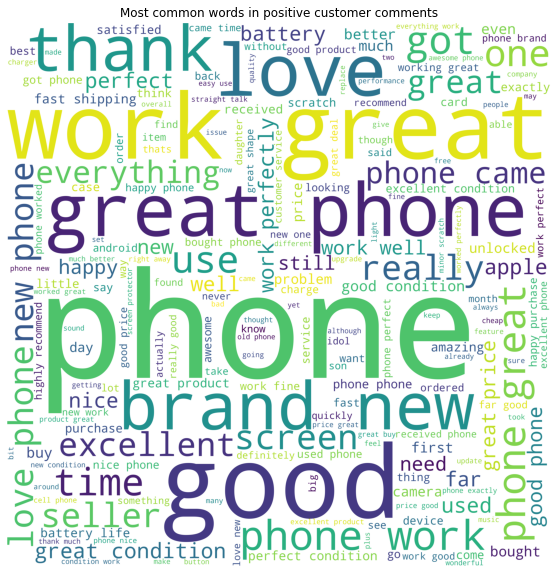

Time taken to build positive wordcloud ::: 0.8068 min  or  48.4077 sec


In [25]:
a=time.time()
wordcloud = WordCloud(height=4000, width=4000, background_color='white')
wordcloud = wordcloud.generate(' '.join(pos_reviews))
plt.figure( figsize=(20,10))
plt.imshow(wordcloud)
plt.title("Most common words in positive customer comments")
plt.axis('off')
plt.show()
print("Time taken to build positive wordcloud :::",calcTime(a))

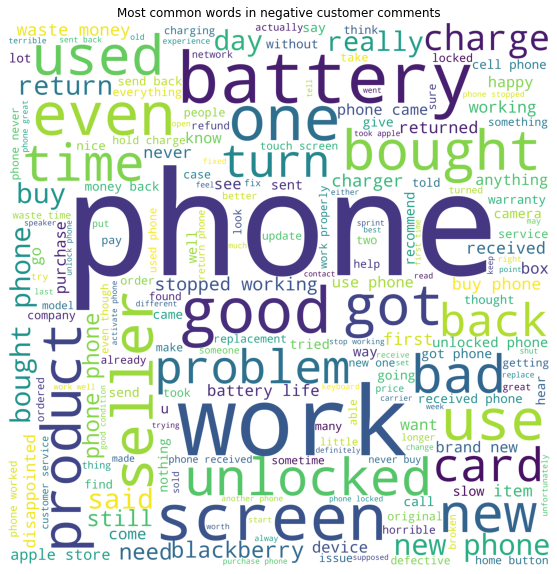

Time taken to build negative wordcloud ::: 0.8233 min  or  49.3955 sec


In [26]:
a=time.time()
wordcloud = WordCloud(height=4000, width=4000,background_color='white')
wordcloud = wordcloud.generate(' '.join(neg_reviews))
plt.figure( figsize=(20,10))
plt.imshow(wordcloud)
plt.title("Most common words in negative customer comments")
plt.axis('off')
plt.show()
print("Time taken to build negative wordcloud :::",calcTime(a))

In [27]:
print("Shape of complete dataframe : ",amazon_data.shape)
print("Shape of positive dataframe : ",amazon_data_pos.shape)
print("Shape of negative dataframe : ",amazon_data_neg.shape)

Shape of complete dataframe :  (281254, 2)
Shape of positive dataframe :  (20000, 2)
Shape of negative dataframe :  (20000, 2)


Time taken    :::  0.014 min  or  0.8405 sec


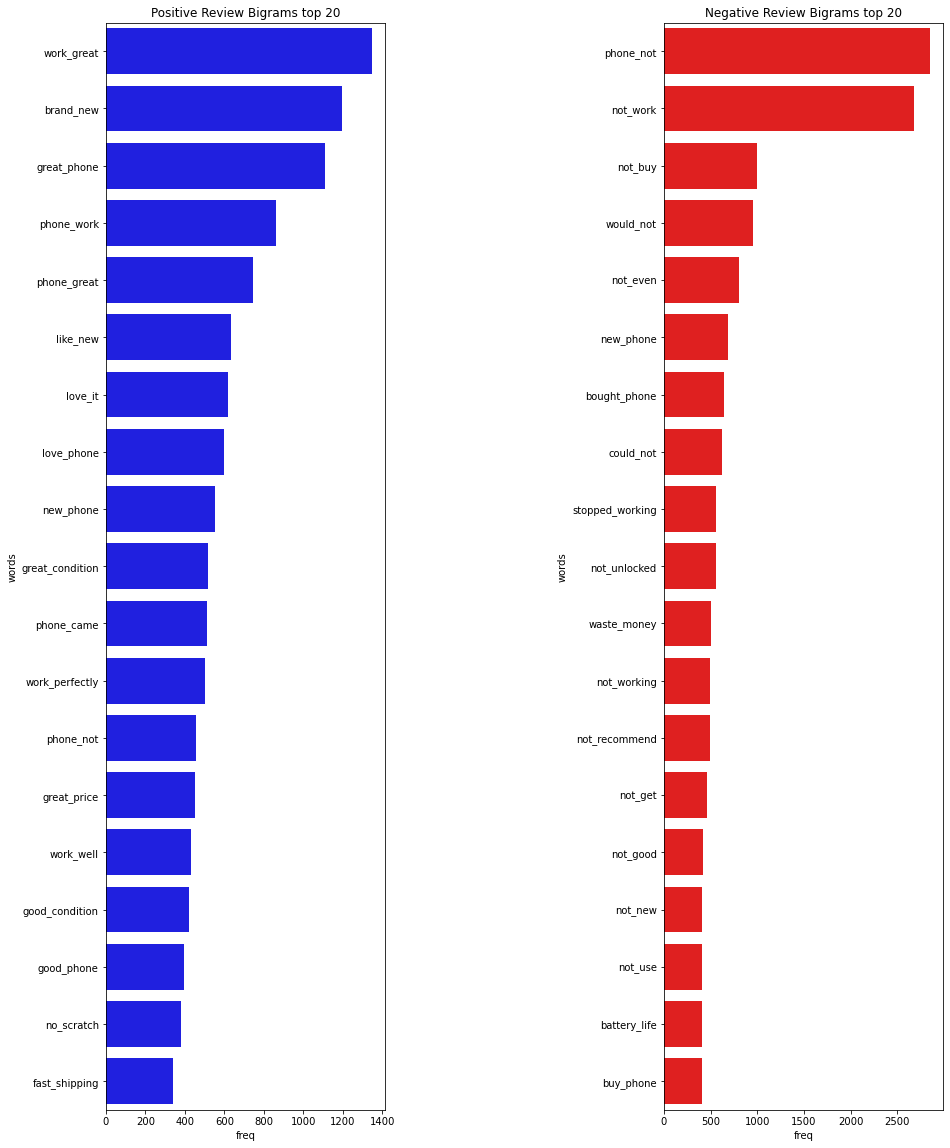

In [28]:
def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn)

def generateNGram(text,n):
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams]


def plotMostCommonWords(reviews_list,topn=30,title="Common Review Words",color="blue",axis=None): #default number of words is given as 30
    top_words=getMostCommon(reviews_list,topn=topn)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    data=data[data['words']!='']    
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(topn))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(topn))
        
        

a=time.time()
positive_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in pos_reviews]
negative_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in neg_reviews]

rcParams['figure.figsize'] = 15,20
fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=1)
plotMostCommonWords(positive_reviews_bigrams,20,'Positive Review Bigrams',axis=ax[0])
plotMostCommonWords(negative_reviews_bigrams,20,'Negative Review Bigrams',color="red",axis=ax[1])
print("Time taken    ::: ",calcTime(a))

                                                 Reviews  r
0      feel lucky found used phone u not used hard al...  1
1      nice phone nice grade revue clean set easy set...  1
2            work good go slow sometimes good phone love  1
3      great phone replace lost phone thing volume bu...  1
4      originally galaxy sprint return back epic spri...  1
...                                                  ... ..
19995  poor audio signal reception used location entr...  0
19996                                        small phone  0
19997  cheap phone cheap quality no volume cannot rea...  0
19998  simple phone upcoming trip one perfect purpose...  0
19999  first received phone excited set phone first w...  0

[40000 rows x 2 columns]


<AxesSubplot:>

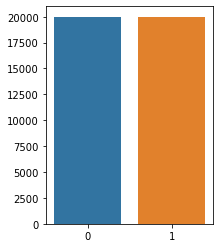

In [29]:
# merging two dataframes to single dataframe as filtered dataframe
amazon_data_filtered =pd.concat([amazon_data_pos,amazon_data_neg])
print(amazon_data_filtered)
plt.figure(figsize=(3,4))
sns.barplot(x=amazon_data_filtered.r.value_counts().index,y=amazon_data_filtered.r.value_counts().values)

In [30]:
# from sklearn.model_selection import train_test_split
# X_train_data, x_test_data,Y_train_data,y_test_data=train_test_split(amazon_data_filtered["Reviews"],amazon_data_filtered["r"],test_size=0.2,shuffle=True)

testsize=int(0.2 * len(amazon_data_pos))
print("Test size is :::",testsize)
amazon_data_test=pd.concat([amazon_data_pos[:testsize],amazon_data_neg[:testsize]])
amazon_data_train=pd.concat([amazon_data_pos[testsize:],amazon_data_neg[testsize:]])


X_train_data , x_test_data = amazon_data_train["Reviews"],amazon_data_test["Reviews"]
Y_train_data , y_test_data = amazon_data_train["r"],amazon_data_test["r"]

print("total shape of dataframe : ",amazon_data_filtered.shape)
print("obtained rows of Y after split (train , test)  : (",Y_train_data.shape[0],",", y_test_data.shape[0],")")
print("obtained rows of X after split (train , test)  : (",X_train_data.shape[0],",", x_test_data.shape[0],")")
#print("sum =", sum((Y_train_data.shape[0],y_test_data.shape[0])))
print( amazon_data_test.r.value_counts(),amazon_data_train.r.value_counts(),"\n", sep="\n\n")
print(Y_train_data.value_counts(),"\n\n")
print( y_test_data.value_counts(),"\n\n")
print(X_train_data.value_counts(),"\n\n")
print( x_test_data.value_counts(),"\n\n")

Test size is ::: 4000
total shape of dataframe :  (40000, 2)
obtained rows of Y after split (train , test)  : ( 32000 , 8000 )
obtained rows of X after split (train , test)  : ( 32000 , 8000 )
1    4000
0    4000
Name: r, dtype: int64

1    16000
0    16000
Name: r, dtype: int64



1    16000
0    16000
Name: r, dtype: int64 


1    4000
0    4000
Name: r, dtype: int64 


good                                                                                                                                                                              400
great                                                                                                                                                                             260
perfect                                                                                                                                                                           192
excellent                                                                      

## Feature Extraction

In [31]:
#tfidf Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vector=TfidfVectorizer(stop_words= STOPWORDS)

tfidf_vector.fit(X_train_data)
print(tfidf_vector.get_feature_names()[:20])

print(tfidf_vector.get_feature_names()[-28])


['abandoned', 'ability', 'able', 'abnormal', 'abort', 'abrasion', 'abreast', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'abstinence', 'absurd', 'abuse', 'abut', 'abysmal', 'acceder', 'accelerated', 'accent']
wrote


In [32]:
X_train_data_new=tfidf_vector.transform(X_train_data)

print(X_train_data_new.shape)

x_test_data_new=tfidf_vector.transform(x_test_data)

(32000, 5567)


In [33]:
print(X_train_data_new,Y_train_data)
# xczx

  (0, 5504)	0.10310379997216013
  (0, 5262)	0.1422460104144521
  (0, 4903)	0.19630538591270238
  (0, 3515)	0.4036627489496557
  (0, 3474)	0.06659237191889127
  (0, 3460)	0.27991564126870816
  (0, 3261)	0.13433940476385084
  (0, 3222)	0.21579898884744225
  (0, 3142)	0.17478101800682364
  (0, 2143)	0.10828482201073894
  (0, 2112)	0.1395400392133233
  (0, 1663)	0.16537846991738855
  (0, 1619)	0.39236079744083724
  (0, 1577)	0.2244832459840811
  (0, 1537)	0.20961777053236968
  (0, 1303)	0.19928882949010468
  (0, 1036)	0.3173420219909039
  (0, 821)	0.2822272642083868
  (0, 238)	0.15742306344709878
  (0, 220)	0.19499134181645492
  (1, 5452)	0.2491315611664244
  (1, 5401)	0.19857634920804287
  (1, 5186)	0.22866684656439093
  (1, 4941)	0.14393138177440104
  (1, 4904)	0.2708610459405699
  :	:
  (31999, 4041)	0.12727075447215608
  (31999, 3846)	0.1299517263167916
  (31999, 3834)	0.11873360869376709
  (31999, 3833)	0.1645910740673526
  (31999, 3762)	0.23137155615162028
  (31999, 3664)	0.106710454

In [34]:
def modelAnalyzer(classifierName):
    print("\n\n",classifierName," Classifier",sep="") 
    print("Accuracy                :::", accuracy[classifierName])
    #Generating Confusion matrix
    print("Confusion matrix        :::")
    print(confusion_matrix(y_test_data, predictions[classifierName]))
    
    
    cf_matrix=confusion_matrix(y_test_data, predictions[classifierName])
    #using the heat map to find how they are correlated
    plt.figure(figsize=(5,5))
    sns.heatmap(cf_matrix, annot=True,fmt="0.1f")
    #sns.heatmap(corr,cbar=True,annot=True,fmt="0.1f",cmap='plasma_r',square=True)
    plt.show()

    #Calculating Precision, Recall and Measure
    print("\nclassification report   :::")
    print(classification_report(y_test_data, predictions[classifierName], target_names=["Positive", "Negative"]))

    #Generating ROC curve
    false_positive, true_positive,_= roc_curve(y_test_data,predictions[classifierName])
    plt.figure(figsize=(7,6))
    plt.title("Receiver operating characteristic curve")
    plt.plot(false_positive, true_positive)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()


In [35]:
predictions=dict()
accuracy=dict()
models=dict()



SVM classifier
Please be patient. This may take some time.
Train Started
Time taken to fit       ::: 3.0946 min  or  185.6747 sec
Time taken to predict   ::: 0.255 min  or  15.2978 sec
Accuracy                ::: 0.886625


SVM Classifier
Accuracy                ::: 0.886625
Confusion matrix        :::
[[3725  275]
 [ 632 3368]]


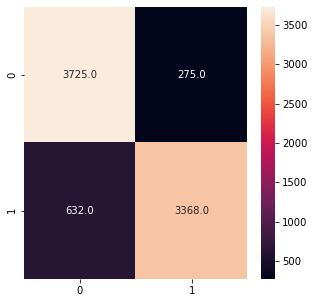


classification report   :::
              precision    recall  f1-score   support

    Positive       0.85      0.93      0.89      4000
    Negative       0.92      0.84      0.88      4000

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



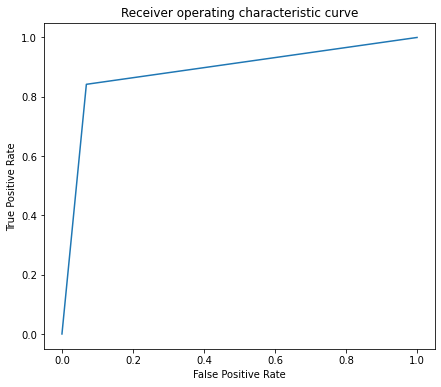

Overall time taken for SVM classifier ::: 3.3632 min  or  201.7926 sec


In [36]:
#1. SVM classifier
print("\n\nSVM classifier") 
print("Please be patient. This may take some time.")
models["SVM"]=SVC()

#Train Model
print("Train Started")
aaa=time.time()
models["SVM"].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions['SVM']=models["SVM"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

# Calculating model accuracy
accuracy['SVM']=accuracy_score(y_test_data, predictions['SVM'])
print("Accuracy                :::", accuracy['SVM'])

modelAnalyzer('SVM')
print("Overall time taken for SVM classifier :::",calcTime(aaa))



RandomForest Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.6031 min  or  36.1876 sec
Time taken to predict   ::: 0.0086 min  or  0.518 sec
Accuracy                ::: 0.854125


RandomForest Classifier
Accuracy                ::: 0.854125
Confusion matrix        :::
[[3733  267]
 [ 900 3100]]


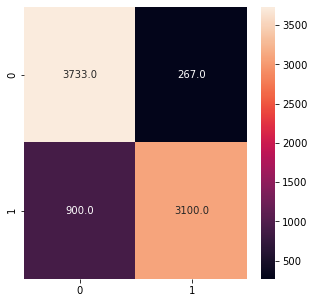


classification report   :::
              precision    recall  f1-score   support

    Positive       0.81      0.93      0.86      4000
    Negative       0.92      0.78      0.84      4000

    accuracy                           0.85      8000
   macro avg       0.86      0.85      0.85      8000
weighted avg       0.86      0.85      0.85      8000



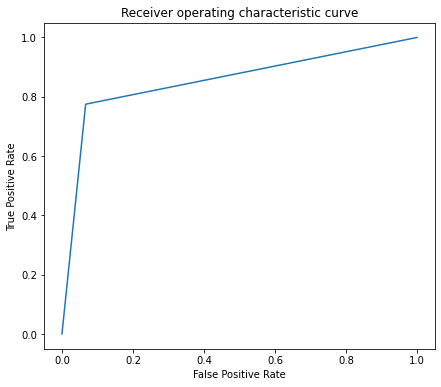

Overall time taken for RandomForest Classifier ::: 0.6242 min  or  37.4517 sec


In [37]:
#2. RandomForest Classifier

print("\n\nRandomForest Classifier") 
print("Please be patient. This may take some time")

models["RandomForest"]=RandomForestClassifier()
#Train Model
print("Train Started")
aaa=time.time()
models["RandomForest"].fit(X_train_data_new ,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions ["RandomForest"]=models["RandomForest"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["RandomForest"]=accuracy_score(y_test_data, predictions["RandomForest"])
print("Accuracy                :::", accuracy["RandomForest"])

modelAnalyzer("RandomForest")

print("Overall time taken for RandomForest Classifier :::",calcTime(aaa))



Multinomial Naive Bayes Classifier
Train Started
Time taken to fit       ::: 0.0003 min  or  0.016 sec
Time taken to predict   ::: 0.0001 min  or  0.003 sec
Accuracy                ::: 0.84725


Multinomial Naive Bayes Classifier
Accuracy                ::: 0.84725
Confusion matrix        :::
[[3719  281]
 [ 941 3059]]


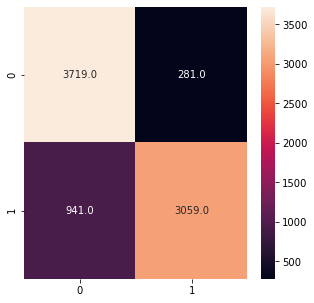


classification report   :::
              precision    recall  f1-score   support

    Positive       0.80      0.93      0.86      4000
    Negative       0.92      0.76      0.83      4000

    accuracy                           0.85      8000
   macro avg       0.86      0.85      0.85      8000
weighted avg       0.86      0.85      0.85      8000



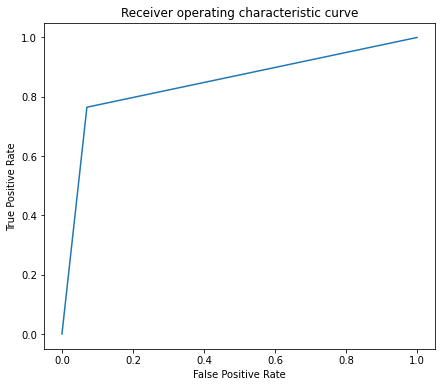

Overall time taken for Multinomial Naive Bayes Classifier::: 0.0143 min  or  0.8605 sec


In [38]:
#3. Multinomial Naive Bayes Classifier

print("\n\nMultinomial Naive Bayes Classifier") 

models["Multinomial Naive Bayes"]=MultinomialNB()
#Train Model
print("Train Started")
aaa=time.time()
models["Multinomial Naive Bayes"].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions["Multinomial Naive Bayes"]=models["Multinomial Naive Bayes"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["Multinomial Naive Bayes"]=accuracy_score(y_test_data, predictions["Multinomial Naive Bayes"])
print("Accuracy                :::", accuracy["Multinomial Naive Bayes"])

modelAnalyzer("Multinomial Naive Bayes")

print("Overall time taken for Multinomial Naive Bayes Classifier:::",calcTime(aaa))



Bernoulli Naive Bayes Classifier
Train Started
Time taken to fit       ::: 0.0004 min  or  0.021 sec
Time taken to predict   ::: 0.0001 min  or  0.005 sec
Accuracy                ::: 0.733


Bernoulli Naive Bayes Classifier
Accuracy                ::: 0.733
Confusion matrix        :::
[[2790 1210]
 [ 926 3074]]


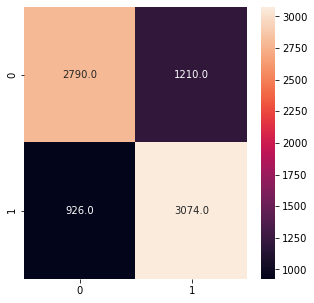


classification report   :::
              precision    recall  f1-score   support

    Positive       0.75      0.70      0.72      4000
    Negative       0.72      0.77      0.74      4000

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000



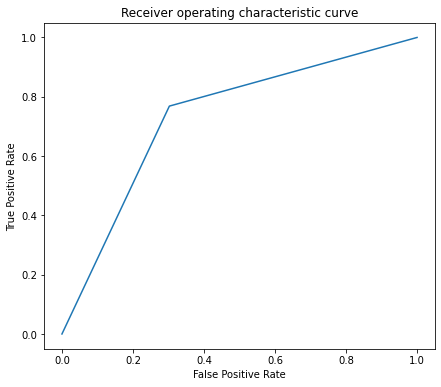

Overall time taken for Bernoulli Naive Bayes Classifier ::: 0.0154 min  or  0.9252 sec


In [39]:
#4. Bernoulli Naive Bayes Classifier

print("\n\nBernoulli Naive Bayes Classifier") 

models["Bernoulli Naive Bayes"]=BernoulliNB()
#Train Model
print("Train Started")
aaa=time.time()
models["Bernoulli Naive Bayes"].fit(X_train_data_new ,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions ["Bernoulli Naive Bayes"]=models["Bernoulli Naive Bayes"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["Bernoulli Naive Bayes"]=accuracy_score(y_test_data, predictions["Bernoulli Naive Bayes"])
print("Accuracy                :::", accuracy["Bernoulli Naive Bayes"])

modelAnalyzer("Bernoulli Naive Bayes")

print("Overall time taken for Bernoulli Naive Bayes Classifier :::",calcTime(aaa))



KNeighbors Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.0002 min  or  0.012 sec
Time taken to predict   ::: 0.2626 min  or  15.7584 sec
Accuracy                ::: 0.65575


KNeighbors Classifier
Accuracy                ::: 0.65575
Confusion matrix        :::
[[1429 2571]
 [ 183 3817]]


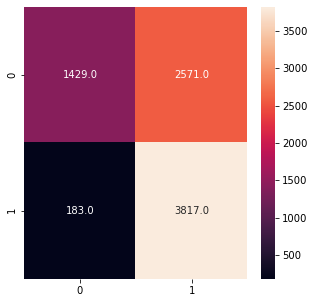


classification report   :::
              precision    recall  f1-score   support

    Positive       0.89      0.36      0.51      4000
    Negative       0.60      0.95      0.73      4000

    accuracy                           0.66      8000
   macro avg       0.74      0.66      0.62      8000
weighted avg       0.74      0.66      0.62      8000



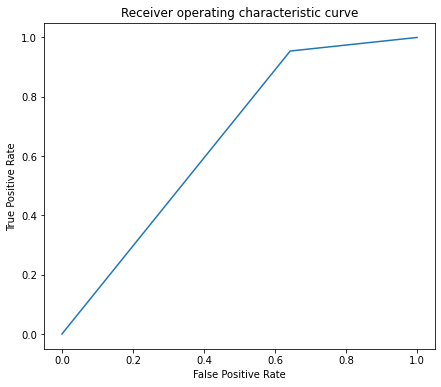

Overall time taken for RandomForest Classifier ::: 0.2993 min  or  17.9556 sec


In [40]:
#5. k-NN Classifier  

print("\n\nKNeighbors Classifier")
print("Please be patient. This may take some time")

models["KNeighbors"]= KNeighborsClassifier(n_neighbors=1)

#Train Model
print("Train Started")
aaa=time.time()
models["KNeighbors"].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions["KNeighbors"] = models["KNeighbors"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["KNeighbors"]=accuracy_score(y_test_data, predictions["KNeighbors"])
print("Accuracy                :::", accuracy["KNeighbors"])

modelAnalyzer("KNeighbors")

print("Overall time taken for RandomForest Classifier :::",calcTime(aaa))



Logistic Regression Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.0114 min  or  0.684 sec
Time taken to predict   ::: 0.0001 min  or  0.004 sec
Accuracy                ::: 0.8765


LogisticRegression Classifier
Accuracy                ::: 0.8765
Confusion matrix        :::
[[3726  274]
 [ 714 3286]]


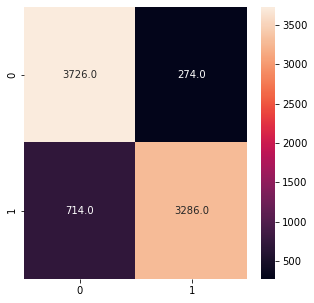


classification report   :::
              precision    recall  f1-score   support

    Positive       0.84      0.93      0.88      4000
    Negative       0.92      0.82      0.87      4000

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



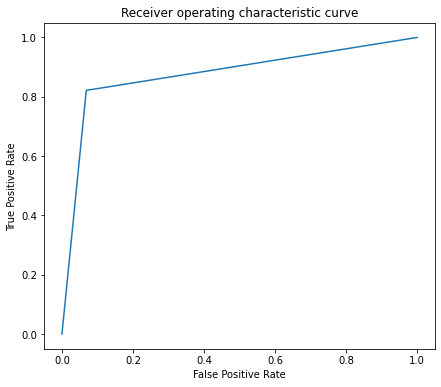

Overall time taken for LogisticRegression Classifier ::: 0.025 min  or  1.5011 sec


In [41]:
#6.  Logistic Regression Classifier

print("\n\nLogistic Regression Classifier")
print("Please be patient. This may take some time")

models['LogisticRegression'] = LogisticRegression()

#Train Model
print("Train Started")
aaa=time.time()
models['LogisticRegression'].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions['LogisticRegression'] = models['LogisticRegression'].predict(x_test_data_new)

print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy['LogisticRegression']=accuracy_score(y_test_data, predictions['LogisticRegression'])
print("Accuracy                :::", accuracy['LogisticRegression'])

modelAnalyzer('LogisticRegression')

print("Overall time taken for LogisticRegression Classifier :::",calcTime(aaa))



Decision Tree Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.131 min  or  7.86 sec
Time taken to predict   ::: 0.0002 min  or  0.0102 sec
Accuracy                ::: 0.815625


DecisionTree Classifier
Accuracy                ::: 0.815625
Confusion matrix        :::
[[3408  592]
 [ 883 3117]]


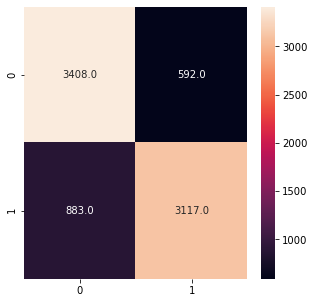


classification report   :::
              precision    recall  f1-score   support

    Positive       0.79      0.85      0.82      4000
    Negative       0.84      0.78      0.81      4000

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000



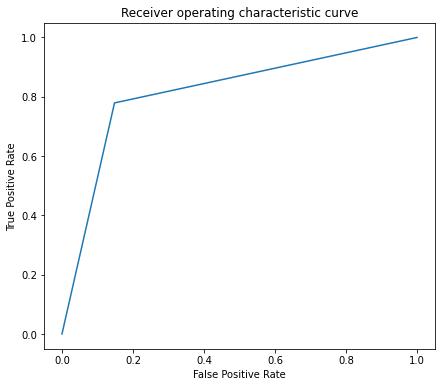

Overall time taken for DecisionTree Classifier ::: 0.1446 min  or  8.6776 sec


In [42]:
#7. Decision Tree Classifier  
print("\n\nDecision Tree Classifier")
print("Please be patient. This may take some time")

models["DecisionTree"] = DecisionTreeClassifier()

#Train Model
print("Train Started")
aaa=time.time()
models["DecisionTree"].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions["DecisionTree"] = models["DecisionTree"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["DecisionTree"]=accuracy_score(y_test_data, predictions["DecisionTree"])
print("Accuracy                :::", accuracy["DecisionTree"])

modelAnalyzer("DecisionTree")

print("Overall time taken for DecisionTree Classifier :::",calcTime(aaa))

In [43]:
#!pip install xgboost

[11:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken to train     ::: 0.1991 min  or  11.9452 sec
Time taken to predict   ::: 0.3811 min  or  22.8675 sec


XGB Classifier
Accuracy                ::: 0.852875
Confusion matrix        :::
[[3621  379]
 [ 798 3202]]


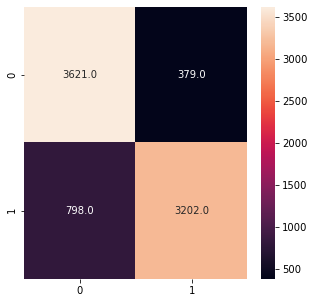


classification report   :::
              precision    recall  f1-score   support

    Positive       0.82      0.91      0.86      4000
    Negative       0.89      0.80      0.84      4000

    accuracy                           0.85      8000
   macro avg       0.86      0.85      0.85      8000
weighted avg       0.86      0.85      0.85      8000



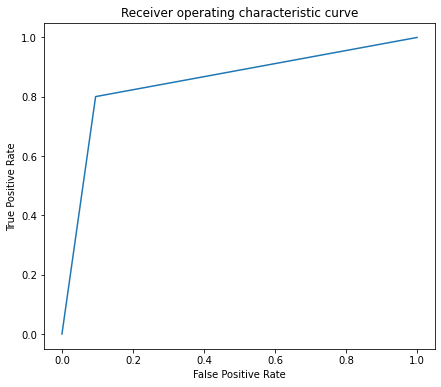

Overall time taken for XGBoost ::: 0.381 min  or  22.8616 sec


In [44]:
#8. XGB Classifier 

xgb_train = xgb.DMatrix(X_train_data_new, Y_train_data)
xgb_test = xgb.DMatrix(x_test_data_new, y_test_data)

# Setting the Parameters of the Model
param = {'eta': 0.75,
         'max_depth': 50,
         'objective': 'binary:logitraw'}
# Training the Model
aaa=time.time()
models["XGB"]= xgb.train(param, xgb_train, num_boost_round = 30)
print("Time taken to train     :::",calcTime(aaa))

# Predicting using the Model
x==time.time()

predictedXgb=[]
for i in range(len(x_test_data)):
    predictedXgb.append(1 if models["XGB"].predict(xgb.DMatrix(x_test_data_new[i]))>0 else 0)
#     if(predictedXgb[-1]!=y_test_data.iloc[i]):
#         print(i,x_test_data.iloc[i][:100],(predictedXgb[-1],y_test_data.iloc[i]))
predictions["XGB"]= np.array(predictedXgb,dtype='int64')
print("Time taken to predict   :::",calcTime(x))

accuracy["XGB"]=accuracy_score(predictions["XGB"],y_test_data)

modelAnalyzer("XGB")

print("Overall time taken for XGBoost :::",calcTime(aaa))

In [45]:
accuracy.keys()

dict_keys(['SVM', 'RandomForest', 'Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'KNeighbors', 'LogisticRegression', 'DecisionTree', 'XGB'])

In [46]:
predictions

{'SVM': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'RandomForest': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'Multinomial Naive Bayes': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'Bernoulli Naive Bayes': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'KNeighbors': array([1, 1, 0, ..., 1, 1, 1], dtype=int64),
 'LogisticRegression': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'DecisionTree': array([1, 1, 1, ..., 0, 1, 0], dtype=int64),
 'XGB': array([1, 1, 1, ..., 0, 0, 0], dtype=int64)}

Classifier Model
1: SVM
2: RandomForest
3: Multinomial Naive Bayes
4: Bernoulli Naive Bayes
5: KNeighbors
6: LogisticRegression
7: DecisionTree
8: XGB
Enter your choice
2
Details are


RandomForest Classifier
Accuracy                ::: 0.854125
Confusion matrix        :::
[[3733  267]
 [ 900 3100]]


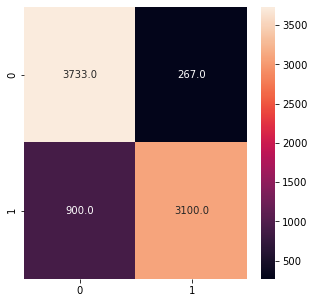


classification report   :::
              precision    recall  f1-score   support

    Positive       0.81      0.93      0.86      4000
    Negative       0.92      0.78      0.84      4000

    accuracy                           0.85      8000
   macro avg       0.86      0.85      0.85      8000
weighted avg       0.86      0.85      0.85      8000



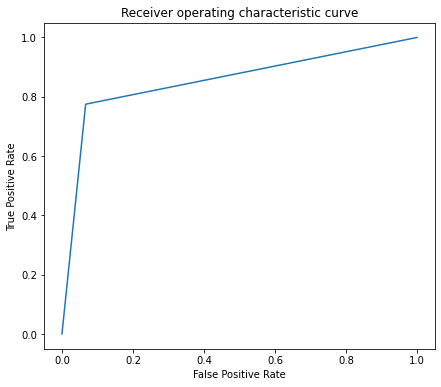

In [47]:
def analyze_each():
    def get_Details(choice): 
        print("Details are")
        modelAnalyzer(list(predictions.keys())[choice-1])
    print("Classifier Model") 
    i=1
    for classifier in predictions.keys():
        print(i,": ",classifier,sep="")
        i+=1
    print("Enter your choice")
    choice=int(input())
    get_Details(choice)
    
analyze_each()

In [48]:
def ensembget(index):
    l=[]
    
    for model in list(["SVM","LogisticRegression","RandomForest","XGB"]):
        l.append(predictions[model][index])

    return statistics.mode(l)

def get_ensemble_accuracy(y_data):

    yhats =[ensembget(xd) for xd in range(len(x_test_data))]
    return accuracy_score(y_data,yhats)

accuracy["Customised"]=get_ensemble_accuracy(y_test_data)
print("Overall Accuracy calculated using mode  :::", accuracy["Customised"])


Overall Accuracy calculated using mode  ::: 0.885125


In [49]:
def predict_rating(): 
    print("\n\nCustomer Review  :::")
    
    Inp_text=input()

    
    review=filter_text(Inp_text)
    new_test_transform = tfidf_vector.transform([review])
    
    def getPredictionMode(new_test_transform):
        l=[]
        for model in ["SVM","LogisticRegression","RandomForest"]:
            l.append(models[model].predict(new_test_transform)[0])
        l.append(1 if models["XGB"].predict(xgb.DMatrix(new_test_transform))[0]>0 else 0)

        return statistics.mode(l)


    Out_text="Positive" if getPredictionMode(new_test_transform) else "Negative"
    
    print()
    print ("Rating  :::", Out_text)
    print("\n")
predict_rating()




Customer Review  :::
not good

Rating  ::: Negative






Calculating Accuracy of each model


                     Model  Accuracy
0                      SVM  0.886625
1             RandomForest  0.854125
2  Multinomial Naive Bayes  0.847250
3    Bernoulli Naive Bayes  0.733000
4               KNeighbors  0.655750
5       LogisticRegression  0.876500
6             DecisionTree  0.815625
7                      XGB  0.852875
8               Customised  0.885125


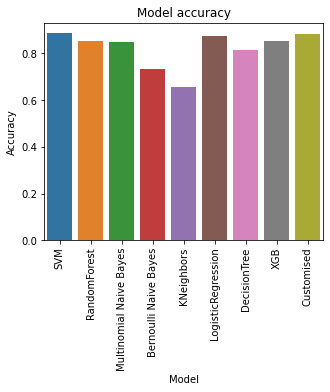

In [50]:
def compare_models():
    
    print("\n\nCalculating Accuracy of each model\n\n")
    
    #Model Accuracy Table    
    result_table=pd.DataFrame(list(accuracy.items()), columns=["Model", "Accuracy"]) 
    #result_table["Accuracy"]=round(result_table["Accuracy"]*100,2)
    print (result_table)
    plt.figure(figsize =(5,4))   #

    sns.barplot(x="Model", y="Accuracy", data =result_table) 
    plt.title("Model accuracy")

    plt.xticks (rotation = 90)  #
    plt.show()


compare_models()


In [51]:
print("Overall time taken for Sentimental Analysis :::",calcTime(Time_Start))

Overall time taken for Sentimental Analysis ::: 9.365 min  or  561.9018 sec


In [ ]:
def actions(choice):
    if choice==1: 
        analyze_each()
    elif choice==2:
        predict_rating() 
    else:
        compare_models() 
        #time.sleep(10)
            
print("Sentiment Analysis of Customer Reviews") 
while(True):
    print("1: Analyze the model")
    print("2: Predict the Rating")
    print("3: Compare the Models")
    print("4: Quit")
    choice=int(input())
    if(choice == 4):
        break
    actions(choice)


Sentiment Analysis of Customer Reviews
1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit
